In [ ]:
import scipy.stats as ms
import pandas as pd
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib
from math import sqrt
from numpy.lib.arraysetops import intersect1d, union1d
import seaborn as sns
from numpy.core.fromnumeric import argmax, argsort
import os

#Criteria pairwise comparison

In [ ]:
def get_criteria_comparison_data(file_path, DM_number):
  skiprows = 0
  data = dict()
  for i in range(DM_number):
    DM = "DM{}".format(i+1)
    pw_matrix = pd.read_excel(file_path, engine = 'openpyxl', usecols="B:F", skiprows=skiprows, nrows=5)
    data[DM] = pw_matrix
    skiprows += 6
  return data

In [ ]:
def normalization(PCM):
    return PCM/np.sum(PCM, axis = 0)

In [ ]:
def CPVs(PCM, criteria: list):
    PCM = normalization(PCM)
    priorities = {}
    n = PCM.shape[0]
    sum_tab = np.sum(PCM, axis = 1)
    for i in range(n):
        priorities[criteria[i]] = sum_tab[i] / n

    return priorities

In [ ]:
def criteria_priority_values(criteria_data ,criteria, DMs):
  priorities = list()
  for dm in DMs:
    normalized_PCM = normalization(criteria_data[dm].to_numpy())
    priorities.append(CPVs(normalized_PCM, criteria))
  return priorities

In [ ]:
def are_consent(pairwise_array1, pairwise_array2, max_dist):
  return not np.any(np.abs(pairwise_array1-pairwise_array2) > max_dist)

In [ ]:
def update_cons(array1,array2,cons_matrix):
  n = array1.shape[0]
  for i in range(n-1):
    for j in range(i+1,n):
      if abs(cons_matrix[i,j]) > abs(cons_matrix[j,i]):
        array1[i,j] = array1[i,j]-cons_matrix[i,j]
        array2[i,j] = array2[i,j]+cons_matrix[i,j]
        array1[j,i] = 1/array1[i,j]
        array2[j,i] = 1/array2[i,j]
      else:
        array1[j,i] = array1[j,i]-cons_matrix[j,i]
        array2[j,i] = array2[j,i]+cons_matrix[j,i]
        array1[i,j] = 1/array1[j,i]
        array2[i,j] = 1/array2[j,i]

  return array1, array2

In [ ]:
def consensus_operation(criteria_comparison_data, consensus_level, DMs, index_max_dist):
  consensus_index = consensus_level/2
  i,j = index_max_dist
  dm1 = DMs[i]
  dm2 = DMs[j]
  array1 = criteria_comparison_data[dm1].copy().to_numpy()
  array2 = criteria_comparison_data[dm2].copy().to_numpy()

  consensus_matrix = (array1 - array2)*consensus_index
  return update_cons(array1, array2, consensus_matrix)

In [ ]:
def distance(pairwise_array1, pairwise_array2):
  return np.linalg.norm(pairwise_array1-pairwise_array2)

In [ ]:
def get_distance_matrix(criteria_comparison_data, DM_number):
  DMs = list(criteria_comparison_data.keys())
  distance_matrix = np.zeros((DM_number,DM_number))
  for i in range(DM_number-1):
    DM1 = DMs[i]
    pairwise_array1 = criteria_comparison_data[DM1].copy()
    for j in range(i+1,DM_number):
      DM2 = DMs[j]
      pairwise_array2 = criteria_comparison_data[DM2].copy()
      distance_matrix[i,j] = distance_matrix[j,i] = distance(pairwise_array1,pairwise_array2)
  return distance_matrix

In [ ]:
def criteria_consensus(criteria_comparison, consensus_level,scale_value, DM_number, iter_number):
  criteria_comparison_data = criteria_comparison.copy()
  max_allowed_dist = (scale_value-1/scale_value)*(1-consensus_level)
  columns = list(criteria_comparison_data["DM1"].columns)
  DMs = list(criteria_comparison_data.keys())
  n = 0
  while True:
    n += 1
    distance_matrix = get_distance_matrix(criteria_comparison_data, DM_number)
    index_max_dist = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    i, j = index_max_dist
    dm1 = DMs[i]
    dm2 = DMs[j]
    array1 = criteria_comparison_data[dm1].copy()
    array2 = criteria_comparison_data[dm2].copy()
    if are_consent(array1, array2,max_allowed_dist):
      break
    array1, array2 = consensus_operation(criteria_comparison_data, consensus_level, DMs,index_max_dist)
    criteria_comparison_data[dm1] = pd.DataFrame(array1, columns=columns)
    criteria_comparison_data[dm2] = pd.DataFrame(array2, columns=columns)
    if n == iter_number:
      break
  return criteria_comparison_data

#Dempster-Shafer phase

In [ ]:
def get_alternatives_matrix(file_path, criteria_list):
  skiprows = 0
  criteria_number = len(criteria_list)
  data = dict()
  for criterion in criteria_list:
    pw_matrix = pd.read_excel(file_path, engine = 'openpyxl', usecols="B:E", skiprows=skiprows, nrows=3)
    data[criterion] = pw_matrix
    skiprows += 4
  return data

In [ ]:
def DM_BOEs(decision_data, criteria_list):
  DM_number = decision_data[criteria_list[0]].shape[0]
  alternatives = decision_data[criteria_list[0]].columns.values
  DM_judgements = []
  for i in range(DM_number):
    criteria_BOE = {}
    for criterion in criteria_list:
      df = decision_data[criterion].copy()
      dm_data = df.iloc[i,:].to_numpy()
      filter = np.isnan(dm_data) == False
      temp = alternatives[filter]
      favorability = dm_data[filter]
      criteria_BOE[criterion] = focal_elements(favorability, temp)
      favorability = []
      DM_judgements.append(criteria_BOE)

  return DM_judgements

In [ ]:
"""
Fonction qui prend en entrée la liste de favorabilités et l'ensemble des alternatives
puis regroupe les aternatives ayant la même favorabilité dans un dictionnaire
"""
def focal_elements(favorability: list, alternatives: list):
    fTemp = favorability[:]
    n = len(fTemp)
    focal_element = []
    f_dict = dict()

    for i in range(n):

        if fTemp[i]  != 0:
            focal_element.append(alternatives[i])
        for j in range(i+1, n):
            if fTemp[i] == fTemp[j] and fTemp[i] != 0:
                focal_element.append(alternatives[j])
                fTemp[j] = 0
        if fTemp[i]  != 0:
            f_dict[(fTemp[i])] = focal_element
        focal_element = []

    return f_dict
"""
Fonction qui calcule la valeur de masse d'un élément focal
"""
def mass_value(criterion_BOE: dict, criterion_priority: float, scale_value: int):
    sum_priorities = 0
    for k, v in criterion_BOE.items():
        sum_priorities += k

    mass = (scale_value * criterion_priority) / (sum_priorities * criterion_priority + sqrt(len(criterion_BOE)))
    return mass

"""
Fonction qui calcule le niveau d'ignorance d'un BOE
"""
def ignorance_level(criterion_BOE: dict, criterion_priority: float):
    sum_priorities = 0
    for k, v in criterion_BOE.items():
        sum_priorities += k

    mass = sqrt(len(criterion_BOE)) / (sum_priorities * criterion_priority + sqrt(len(criterion_BOE)))
    return mass


"""
Fonction qui effectue la combinaison des jugements des décideurs
"""
def dempster_combination(boe_tab:list):

    while len(boe_tab) > 1:
        inter=intersect_BOE(boe_tab[0], boe_tab[1])
        boe_tab.pop(0)
        boe_tab[0] = combined_BOE(inter[0],inter[1], inter[2])
    return boe_tab[0]


"""
Fonction qui retourne la somme des valeurs de masse de tous les couples
d'éléments focaux dont leur intersection est nulle
"""
def inter_null_sum(inter_nul: list):
    if type(inter_nul) is list:
        sum = 0
        if inter_nul != []:
            for i in range(len(inter_nul)):
                sum += inter_nul[i][0]*inter_nul[i][1]
        return sum

"""
Fonction qui effectue la combinaison de deux BOE
"""
def combined_BOE(inter_null: list, not_null_inter: list, inter_result: list):
    inter_nul_sum = inter_null_sum(inter_null)
    not_null_tab = not_null_inter
    inter_tab = inter_result
    combined_boe = {}
    j=1
    while inter_tab != []:
        combined_mass_value = not_null_tab[0][0]*not_null_tab[0][1]
        i=1
        while i < len(inter_tab):
            equal = True
            for k in range(len(inter_tab[i])) :
                if inter_tab[i][k] not in inter_tab[0]:
                    equal = False
                    break
            if equal == True:
                combined_mass_value += not_null_tab[i][0]*not_null_tab[i][1]
                inter_tab.pop(i)
                not_null_tab.pop(i)
                continue
            i += 1
        combined_mass_value /= (1-inter_nul_sum)
        combined_boe[(combined_mass_value,j)] = inter_tab[0]
        inter_tab.pop(0)
        not_null_tab.pop(0)
        j += 1
    return combined_boe

"""
Fonction qui effectue l'intersection de deux BOE
"""
def intersect_BOE(BOE1: dict, BOE2: dict):
    inter_null = []
    not_null_inter = []
    inter_result = []
    intersect = []
    for m1,boe1 in BOE1.items():
        for m2,boe2 in  BOE2.items():
            print(boe1, boe2)
            intersect = list(intersect1d(boe1, boe2))
            if intersect == []:
                inter_null.append((m1[0], m2[0]))
            else:
                not_null_inter.append((m1[0], m2[0]))
                inter_result.append(intersect)
    return inter_null, not_null_inter, inter_result


"""
Fonction qui calcule la croyance d'un BOE
"""
def boe_belief(boe:dict):
    tab_mass = []
    tab_foc_element = []
    belief_foc_el = {}
    for m,v in boe.items():
        tab_mass.append(m)
        tab_foc_element.append(v)
    for i in range(len(tab_foc_element)):
        belief_value = tab_mass[i][0]
        for j in range(len(tab_foc_element)):
            if j != i:
                if list(intersect1d(tab_foc_element[j],tab_foc_element[i])) == tab_foc_element[j]:
                    belief_value += tab_mass[j][0]
        belief_foc_el[(belief_value,i)] = tab_foc_element[i]
    return belief_foc_el


"""
Fonction qui calcule la croyance des BOE de tous les décideurs
"""
def DMs_boe_belief(tab_foc:list):
    DMs_boe_tab = []
    for i in range(len(tab_foc)):
        DMs_boe_tab.append(boe_belief(tab_foc[i]))
    return DMs_boe_tab

"""
Fonction qui calcule la plausibilité d'un BOE
"""
def boe_plausibility(boe:dict):
    tab_mass = []
    tab_foc_el = []
    plausi_foc_el = {}
    for m,v in boe.items():
        tab_mass.append(m)
        tab_foc_el.append(v)
    for i in range(len(tab_foc_el)):
        plausi_value = tab_mass[i][0]
        for j in range(len(tab_foc_el)):
            if j != i:
                if list(intersect1d(tab_foc_el[j],tab_foc_el[i])) != []:
                    plausi_value += tab_mass[j][0]
        plausi_foc_el[(plausi_value,i)] = tab_foc_el[i]
    return plausi_foc_el

"""
Fonction qui calcule la plausibilité des BOE de tous les décideurs

"""
def DMs_boe_plausibility(tab_foc:list):
    DMs_boe_tab = []
    for i in range(len(tab_foc)):
        DMs_boe_tab.append(boe_plausibility(tab_foc[i]))
    return DMs_boe_tab

In [ ]:
path = '/content/drive/MyDrive/decision_sheet.xlsx'
criteria = ["fu","gu", "bu", "tu", "xu"]
p = get_alternatives_matrix(path, criteria)
DM_BOEs(p, criteria)


[{'fu': {5: ['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'],
   4: ['Ford Exp King Ranch'],
   7: ['Audi RS Q8']},
  'gu': {2.0: ['2024 BMW 3.0 CSL'],
   4.0: ['Audi RS Q8'],
   5.0: ['Honda CITY HYBRID']},
  'bu': {6.0: ['2024 BMW 3.0 CSL'],
   2.0: ['Ford Exp King Ranch'],
   4.0: ['Audi RS Q8'],
   8.0: ['Honda CITY HYBRID']},
  'tu': {3.0: ['2024 BMW 3.0 CSL'],
   8.0: ['Ford Exp King Ranch'],
   4.0: ['Audi RS Q8', 'Honda CITY HYBRID']},
  'xu': {5.0: ['2024 BMW 3.0 CSL'],
   2.0: ['Ford Exp King Ranch'],
   7.0: ['Audi RS Q8'],
   4.0: ['Honda CITY HYBRID']}},
 {'fu': {5: ['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'],
   4: ['Ford Exp King Ranch'],
   7: ['Audi RS Q8']},
  'gu': {2.0: ['2024 BMW 3.0 CSL'],
   4.0: ['Audi RS Q8'],
   5.0: ['Honda CITY HYBRID']},
  'bu': {6.0: ['2024 BMW 3.0 CSL'],
   2.0: ['Ford Exp King Ranch'],
   4.0: ['Audi RS Q8'],
   8.0: ['Honda CITY HYBRID']},
  'tu': {3.0: ['2024 BMW 3.0 CSL'],
   8.0: ['Ford Exp King Ranch'],
   4.0: ['Audi RS Q8', 'Honda CITY HYB

In [ ]:
def get_final_decision(file_path, decision_path, DM_number):

  df = get_criteria_comparison_data(file_path,DM_number)

  DMs = list(df.keys())
  DM_number = len(DMs)
  criteria_list = list(df["DM1"].columns)

  decision_data = get_alternatives_matrix(decision_path,criteria_list)
  alternatives = list(decision_data[criteria_list[0]].columns)
  alternative_number = len(alternatives)
  priority_values_tab = criteria_priority_values(df, criteria_list, DMs)

  DM_judgements = DM_BOEs(decision_data,criteria_list)

  DMs_BOE = []
  mass = 0
  for i in range(DM_number):
      DM_criteria_BOE = {}
      for criterion, foc_elements in DM_judgements[i].items():
          DM_BOE = {}
          j=1
          for scale_value, focal_element in foc_elements.items():
              mass = mass_value(foc_elements, priority_values_tab[i][criterion], scale_value)
              DM_BOE[mass,j] = focal_element
              j += 1

          mass = ignorance_level(foc_elements, priority_values_tab[i][criterion])
          DM_BOE[mass,j] = alternatives
          DM_criteria_BOE[criterion] = DM_BOE
      DMs_BOE.append(DM_criteria_BOE)

  combined_DMs_BOE = []
  for i in range(DM_number):
      boe_tab = []
      for criterion, BOE in DMs_BOE[i].items():
          boe_tab.append(BOE)
      combined_DMs_BOE.append(dempster_combination(boe_tab))

  DMs_belief = DMs_boe_belief(combined_DMs_BOE)
  DMs_plausibility = DMs_boe_plausibility(combined_DMs_BOE)
  group_BOE = dempster_combination(combined_DMs_BOE)
  group_belief = boe_belief(group_BOE)
  group_plausibility = boe_plausibility(group_BOE)

  return group_belief,group_plausibility,alternative_number

In [ ]:


def print_final_decision(group_belief,group_plausibility,alternative_number):
  print("\n\n\t-------------Croyance et plausibilité de tous les décideurs---------------: \n 1- Croyance \n {} \n\n 2- Plausibilité \n {}".format( DMs_belief,DMs_plausibility))
  print("\n\t -----------Agregation des jugements---------------\n")

  print("\n\n\t------------------Croyance et plausibilité finales------------------: \n 1- Croyance \n {} \n\n 2- Plausibilité \n {}".format( group_belief,group_plausibility))
  print()
  tabMbel = []
  tabFbel = []
  tablen = []
  for m,v in group_belief.items():
      tabMbel.append(m[0])
      tabFbel.append(v)
      tablen.append(len(v))
  a= np.asarray_chkfinite(tablen)
  t = list(argsort(a))
  print("\n\n-----------Classemment des alternatives par croyance--------------\n\n")
  i = t[0]

  print("\t\tEnsemble d'alternative de taille {}\n".format(len(tabFbel[i])))

  k=1
  m_tab = []
  f_tab = []
  for j in t:
      if len(tabFbel[i])<len(tabFbel[j]):
          mass_array = np.asarray_chkfinite(m_tab)
          mass_arg = list(argsort(mass_array))
          mass_arg.reverse()
          for x in mass_arg:
              print("{}-  {}     :     {}\n".format(k,f_tab[x],m_tab[x]))
              k+=1
          m_tab.clear()
          f_tab.clear()
          if len(tabFbel[j]) < alternative_number:
              print("\t\tEnsemble d'alternatives de taille {}\n".format(len(tabFbel[j])))
          i=j
          k=1
      m_tab.append(tabMbel[j])
      f_tab.append(tabFbel[j])

  tabMplausi = []
  tabFplausi = []
  tablenP = []
  for m,v in group_plausibility.items():
      tabMplausi.append(m[0])
      tabFplausi.append(v)
      tablenP.append(len(v))
  aP= np.asarray_chkfinite(tablenP)
  tP = list(argsort(aP))
  print("\n\n-----------Classemment des alternatives par plausibilité--------------\n\n")
  i = tP[0]

  print("\t\tEnsemble d'alternatives de taille {}\n".format(len(tabFplausi[i])))

  k=1
  m_tabP = []
  f_tabP = []
  for j in tP:
      if len(tabFplausi[i])<len(tabFplausi[j]):
          mass_array = np.asarray_chkfinite(m_tabP)
          mass_arg = list(argsort(mass_array))
          mass_arg.reverse()
          for x in mass_arg:
              print("{}-  {}     :     {}\n".format(k,f_tabP[x],m_tabP[x]))
              k+=1
          m_tabP.clear()
          f_tabP.clear()
          if len(tabFplausi[j]) < alternative_number:
              print("\t\tEnsemble d'alternatives de taille {}\n".format(len(tabFplausi[j])))
          i=j
          k=1
      m_tabP.append(tabMplausi[j])
      f_tabP.append(tabFplausi[j])





#Consensus building

##**Step 1 :** Consensus level = 100%

---



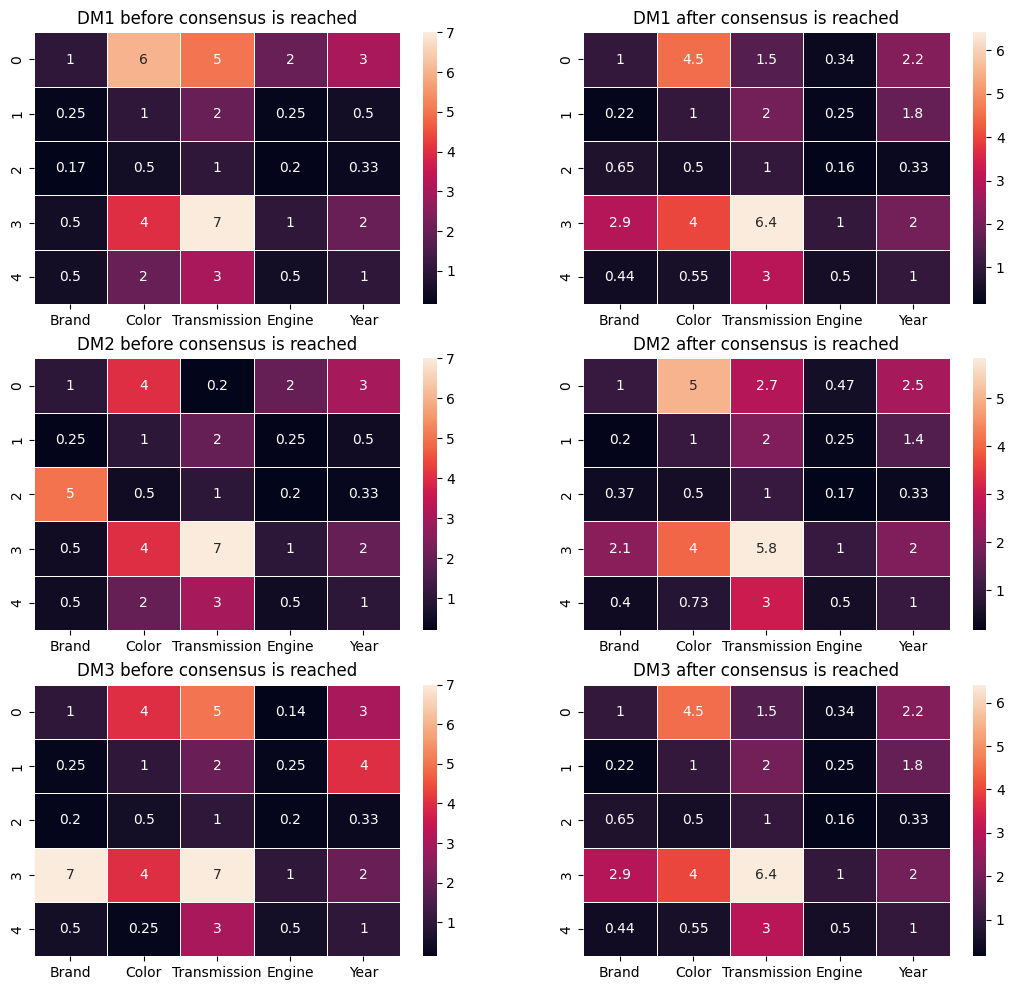

In [ ]:
file_path = '/content/drive/MyDrive/Pairwise.xlsx'
data_before_consensus= get_criteria_comparison_data(file_path,3)
DM_number = len(list(data_before_consensus.keys()))
data_after_consensus = criteria_consensus(data_before_consensus,1,9, DM_number, 3)

fig, ax = plt.subplots(DM_number,2, figsize = (13,12))
for i in range(DM_number):
  dm = "DM{}".format(i+1)
  title1 = dm+" before consensus is reached"
  title2 = dm+" after consensus is reached"
  sns.heatmap(data_before_consensus[dm], annot=True,ax = ax[i][0] ,linewidth=.5)
  sns.heatmap(data_after_consensus[dm], annot=True,ax = ax[i][1] ,linewidth=.5)
  ax[i][0].set_title(title1)
  ax[i][1].set_title(title2)

##**Step 2:** Determine the best consensus level
**The best consensus level minimizes the distance between all decision makers**

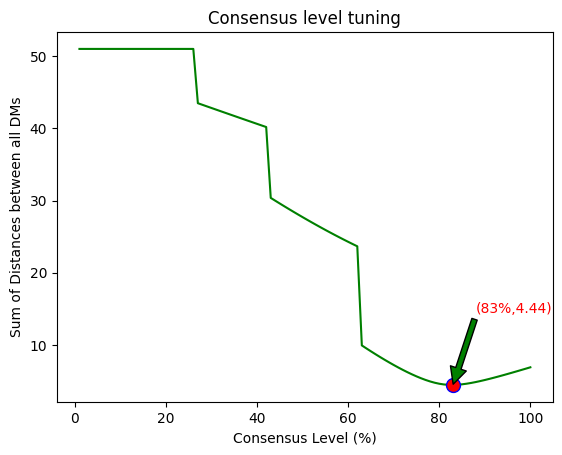

In [ ]:
L = list()
for i in list(np.linspace(0.01,1, 100)):
  DF = criteria_consensus(data_before_consensus,i,9,3,3)
  D = get_distance_matrix(DF,3)
  L.append(np.sum(D))

x = np.argmin(L)
y = L[x]


Text = "({}%,{})".format(x+1,round(y,2))
plt.plot(range(1,101),L, color="green")
plt.plot(x+1, y, marker='o', markersize=10, markerfacecolor='red', markeredgecolor='blue')
plt.xlabel("Consensus Level (%)")
plt.ylabel("Sum of Distances between all DMs")
plt.annotate(Text, xy=(x+1, y), xytext=(x+6, y+10),
            arrowprops=dict(facecolor='green', shrink=0.01), color="red"
            )
plt.title("Consensus level tuning")
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/Pairwise.xlsx'
decision_path = '/content/drive/MyDrive/decision_sheet.xlsx'
criteria_list = list(data_before_consensus["DM1"].columns)
decision_data = get_alternatives_matrix(decision_path, criteria_list)
alternatives = list(decision_data[criteria_list[0]].columns)
gmean = []
amean = []
for criterion in criteria_list:
  mat = decision_data[criterion]
  array1 = np.where(mat>0,mat, 1)
  array2 = np.where(mat>0,mat, 0)
  gmean.append(ms.mstats.gmean(array1))
  amean.append(np.mean(array2,axis = 0))

final_amean =  (np.mean(amean, axis = 0))
final_amean /= np.sum(final_amean)
final_gmean = (ms.mstats.gmean(gmean))
final_gmean /= np.sum(final_gmean)

In [ ]:
belief, plausibility, alternative_number = get_final_decision(file_path, decision_path, 3)
dic = {}
plau = {}
belief_list = []
plau_list = []
for k, v in belief.items():
  if len(v) == 1:
    dic[v[0]] = k[0]

for k, v in plausibility.items():
  if len(v) == 1:
    plau[v[0]] = k[0]

for al in alternatives:
  belief_list.append(dic[al])
  plau_list.append(plau[al])


['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'] ['2024 BMW 3.0 CSL']
['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'] ['Audi RS Q8']
['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'] ['Honda CITY HYBRID']
['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'] ['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY HYBRID']
['Ford Exp King Ranch'] ['2024 BMW 3.0 CSL']
['Ford Exp King Ranch'] ['Audi RS Q8']
['Ford Exp King Ranch'] ['Honda CITY HYBRID']
['Ford Exp King Ranch'] ['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY HYBRID']
['Audi RS Q8'] ['2024 BMW 3.0 CSL']
['Audi RS Q8'] ['Audi RS Q8']
['Audi RS Q8'] ['Honda CITY HYBRID']
['Audi RS Q8'] ['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY HYBRID']
['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY HYBRID'] ['2024 BMW 3.0 CSL']
['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY HYBRID'] ['Audi RS Q8']
['2024 BMW 3.0 CSL', 'Ford Exp King Ranch', 'Audi RS Q8', 'Honda CITY H

In [ ]:
alt  = alternatives*4
hue = []
values = []
hue.extend(["Geometric mean"]*4)
hue.extend(["Arithmetic mean"]*4)
hue.extend(["Belief"]*4)
hue.extend(["Plausibility"]*4)
values.extend(final_gmean)
values.extend(final_amean)
values.extend(belief_list)
values.extend(plau_list)
data = pd.DataFrame({"Alternative":alt,"Value": values,"Measure":hue})
data

,Alternative,Value,Measure
0,2024 BMW 3.0 CSL,0.254795,Geometric mean
1,Ford Exp King Ranch,0.232107,Geometric mean
2,Audi RS Q8,0.215246,Geometric mean
3,Honda CITY HYBRID,0.297852,Geometric mean
4,2024 BMW 3.0 CSL,0.248963,Arithmetic mean
5,Ford Exp King Ranch,0.236515,Arithmetic mean
6,Audi RS Q8,0.224066,Arithmetic mean
7,Honda CITY HYBRID,0.290456,Arithmetic mean
8,2024 BMW 3.0 CSL,0.127555,Belief
9,Ford Exp King Ranch,0.111386,Belief


<Axes: xlabel='Alternative', ylabel='Value'>

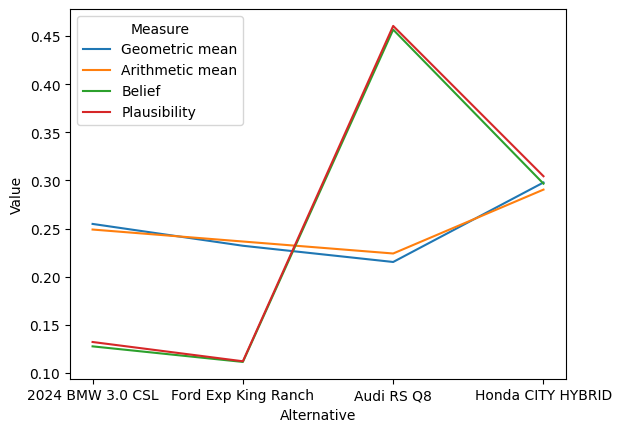

In [ ]:
sns.lineplot(data=data, x="Alternative", y="Value", hue="Measure")

In [ ]:



def get_decision_excel_file(belief, plausibility, alternative_number,path):
  dic_dec_bel = {}

  for i in range(1, alternative_number):
    dic_dec_bel[i] = [[],[]]
  dic_dec_plau = dic_dec_bel.copy()
  for k,v in belief.items():
    if len(v) < alternative_number:
      I = len(v)
      if v not in dic_dec_bel[I][0]:
        dic_dec_bel[I][0].append(v)
        dic_dec_bel[I][1].append(k[0])


  for k,v in plausibility.items():
    if len(v) < alternative_number:
      I = len(v)
      if v not in dic_dec_plau[I][0]:
        dic_dec_plau[I][0].append(v)
        dic_dec_plau[I][1].append(k[0])
  alt1_tab = []
  alt2_tab = []
  bel_tab = []
  plau_tab = []
  for k,v in dic_dec_bel.items():
    if len(v[0]) > 0:
      values = np.array(v[1])
      als= v[0]
      print(als)
      indices = np.argsort(values)[::-1]
      mapper = lambda x: "{}".format(x)
      als = list(map(mapper,als))
      np_als = np.array(als)

      values = values[indices]
      np_als = np_als[indices]
      alt1_tab.extend(np_als)
      bel_tab.extend(values)

  for k,v in dic_dec_plau.items():
    if len(v[0]) > 0:
      values = np.array(v[1])
      als= v[0]
      indices = np.argsort(values)[::-1]
      mapper = lambda x: "{}".format(x)
      als = list(map(mapper,als))
      np_als = np.array(als)
      values = values[indices]
      np_als = np_als[indices]
      alt2_tab.extend(np_als)
      plau_tab.extend(values)

  bel_df = pd.DataFrame({"Alternatives Group":alt1_tab,"Belief":bel_tab})
  plau_df = pd.DataFrame({"Alternatives Group":alt2_tab,"Plausibility":plau_tab})

  path1 = path + "final_decision_belief.xlsx"
  path2 = path + "final_decision_plausibility.xlsx"
  bel_df.to_excel(path1, sheet_name="Ranking_By_Belief")
  plau_df.to_excel(path2, sheet_name="Ranking_By_Plausibility")

In [ ]:
paths = "/content/drive/MyDrive/"
get_decision_excel_file(belief,plausibility,4,paths)

[['2024 BMW 3.0 CSL'], ['Honda CITY HYBRID'], ['Ford Exp King Ranch'], ['Audi RS Q8']]
[['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'], ['Audi RS Q8', 'Honda CITY HYBRID']]


In [ ]:
belief

{(0.12755492718289824, 0): ['2024 BMW 3.0 CSL'],
 (0.2966356130356849, 1): ['Honda CITY HYBRID'],
 (0.42805428571455856, 2): ['2024 BMW 3.0 CSL', 'Honda CITY HYBRID'],
 (0.11138623102505305, 3): ['Ford Exp King Ranch'],
 (0.45669937385668125, 4): ['Audi RS Q8'],
 (0.7565223246859686, 5): ['Audi RS Q8', 'Honda CITY HYBRID'],
 (1.0000000000000058, 6): ['2024 BMW 3.0 CSL',
  'Audi RS Q8',
  'Ford Exp King Ranch',
  'Honda CITY HYBRID']}